In [1]:
from pathlib import Path
import time

import torch
from torch import nn
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [47]:
# Dígito escogido para clasificar
chosen_digit = 8

# Se define una transformación para las imágenes (La primera transforma las imágenes a tensor y la segunda aplana los tensores en vectores)
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda t: t.flatten()),
])

# Se define una transformación para los labels. Esta toma cada label y los transforma a 1 y 0,
# donde 1 representa que el dígito es igual al dígito escogido (en este caso 8) y 0 representa que es otro dígito.
target_transform = torchvision.transforms.Lambda(lambda label: 1 if label == chosen_digit else 0)

# Se descargan los datasets de train y test de mnist y se transforman
root_dataset_dir = "./mnist"

train_mnist_dataset = torchvision.datasets.MNIST(
    root=root_dataset_dir,
    train=True,
    transform=transform, # Acá definimos la transformación a las imágenes
    target_transform=target_transform, # Acá definimos la transformación a los labels
    download=True
)
test_mnist_dataset = torchvision.datasets.MNIST(
    root=root_dataset_dir,
    train=False,
    transform=transform, # Acá definimos la transformación a las imágenes
    target_transform=target_transform, # Acá definimos la transformación a los labels
    download=True
)

# Del dataset de entrenamieno obtenemos una porción que utilizaremos como dataset de validación
# Sabemos que son 60000 datos totales del dataset original de entrenamiento y 10000 de test.
# Por lo tanto tomamos 10000 datos del dataset de entrenamiento y los utilizamos como validación (eliminándolos del dataset de entrenamiento)
train_size = 55000
val_size = len(train_mnist_dataset) - train_size
train_mnist_dataset, val_mnist_dataset = torch.utils.data.random_split(train_mnist_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"El dataset de entrenamiento completo tiene: {len(train_mnist_dataset)} elementos.")
print(f"El dataset de validación tiene: {len(val_mnist_dataset)} elementos.")
print(f"El dataset de test tiene: {len(test_mnist_dataset)} elementos.")

print()

x, y = train_mnist_dataset[0]
print(f"Primer ejemplo obtenido del dataset:")
print(f"Tensor de tamaño: {x.shape} con valor mínimo: {x.min()} y máximo: {x.max()}")
print("Clase:", y)

El dataset de entrenamiento completo tiene: 55000 elementos.
El dataset de validación tiene: 5000 elementos.
El dataset de test tiene: 10000 elementos.

Primer ejemplo obtenido del dataset:
Tensor de tamaño: torch.Size([784]) con valor mínimo: 0.0 y máximo: 1.0
Clase: 0


In [49]:
def balance_dataset(dataset):
    data_tuples = [(x, y) for (x, y) in dataset]  # Separamos el dataset en X, y
    X = torch.stack([t[0] for t in data_tuples])
    y = torch.tensor([t[1] for t in data_tuples])

    final_X = X.float()
    final_y = y

    final_dataset = torch.utils.data.TensorDataset(
        final_X,
        final_y,
    )

    return final_dataset


In [50]:
print("Balanceando dataset de entrenamiento.")
train_mnist_dataset = balance_dataset(train_mnist_dataset)
print()

print("Balanceando dataset de validación.")
val_mnist_dataset = balance_dataset(val_mnist_dataset)
print()

print("Balanceando dataset de test.")
test_mnist_dataset = balance_dataset(test_mnist_dataset)

Balanceando dataset de entrenamiento.

Balanceando dataset de validación.

Balanceando dataset de test.


In [51]:
train_mnist_dataset = torch.utils.data.TensorDataset(
    train_mnist_dataset.tensors[0].view(-1, 1, 28, 28),
    train_mnist_dataset.tensors[1]
)

val_mnist_dataset = torch.utils.data.TensorDataset(
    val_mnist_dataset.tensors[0].view(-1, 1, 28, 28),
    val_mnist_dataset.tensors[1]
)

test_mnist_dataset = torch.utils.data.TensorDataset(
    test_mnist_dataset.tensors[0].view(-1, 1, 28, 28),
    test_mnist_dataset.tensors[1]
)

train_mnist_dataset = torch.utils.data.TensorDataset(
    torch.nn.functional.interpolate(train_mnist_dataset.tensors[0], size=(21, 21)),
    train_mnist_dataset.tensors[1]
)

val_mnist_dataset = torch.utils.data.TensorDataset(
    torch.nn.functional.interpolate(val_mnist_dataset.tensors[0], size=(21, 21)),
    val_mnist_dataset.tensors[1]
)

test_mnist_dataset = torch.utils.data.TensorDataset(
    torch.nn.functional.interpolate(test_mnist_dataset.tensors[0], size=(21, 21)),
    test_mnist_dataset.tensors[1]
)

In [53]:
import importlib
import src.model.train as train
importlib.reload(train)
import src.model.metrics as metrics
importlib.reload(metrics)
import src.model.vae as vae
importlib.reload(vae)

model_ones = vae.VAE(latent_dim=21)

max_epochs = 30
criterion = vae.loss_function
batch_size = 64
lr = 1e-4
early_stop = 20
use_gpu = False

curves, tiempo_ejecucion = train.train_model(model_ones,
                                            train_mnist_dataset,
                                            val_mnist_dataset,
                                            [0],
                                            max_epochs=max_epochs,
                                            criterion=criterion,
                                            batch_size=batch_size,
                                            lr=lr,
                                            early_stopping_tolerance=early_stop,
                                            use_gpu=use_gpu)

Epoch 30/30 -- Iteration 25798 - Batch 858/860 - Train loss: 840.210693



([], [])

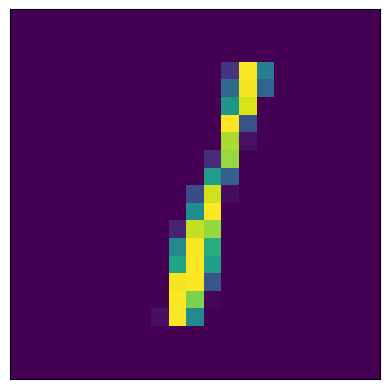

In [85]:
model_ones.eval()
img = test_mnist_dataset[2][0][0]
plt.imshow(img)
plt.yticks([])
plt.xticks([])

/tmp/ipykernel_32297/3418156530.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # Convertir la imagen a tensor


([], [])

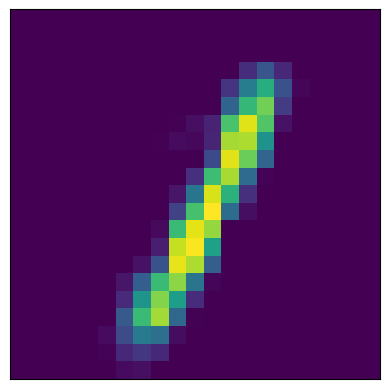

In [93]:


with torch.no_grad():
    img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # Convertir la imagen a tensor
    reconstructed_img = model_ones(img_tensor)[0].squeeze().detach().numpy()

plt.imshow(reconstructed_img)
plt.yticks([])
plt.xticks([])

([], [])

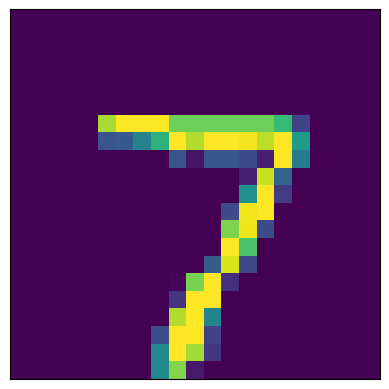

In [94]:
model_ones.eval()
img = test_mnist_dataset[0][0][0]
plt.imshow(img)
plt.yticks([])
plt.xticks([])

/tmp/ipykernel_32297/1527667916.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # Convertir la imagen a tensor


([], [])

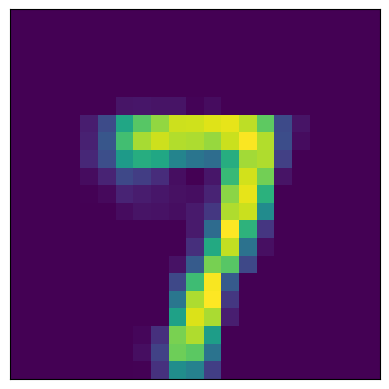

In [95]:
with torch.no_grad():
    img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # Convertir la imagen a tensor
    reconstructed_img = model_ones(img_tensor)[0].squeeze().detach().numpy()

plt.imshow(reconstructed_img)
plt.yticks([])
plt.xticks([])